In [2]:
import numpy as np  
import scipy as sp  
from scipy.fft import fft2  
from scipy.fft import ifft2  
from scipy.fft import fftfreq  
from scipy.fft import fftshift  
import imageio 
import cv2  
import scipy.ndimage as ndi 
import time
from skimage import io as sio  
import skimage  
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap  
from matplotlib import animation  
from matplotlib.animation import PillowWriter  
import pint  
import math  
import pandas as pd
import os
import cv2
u = pint.UnitRegistry()

### Загрузка и обработка CSV

In [3]:
def csv_to_image(csv_file, output_image_path=None):

    data = pd.read_csv(csv_file, sep=';', header=None)
    intensity_data = data.to_numpy()
    plt.imshow(intensity_data, cmap='viridis', origin='lower')
    plt.colorbar()  

    if output_image_path:
        plt.savefig(output_image_path)
        print(f"Image saved as {output_image_path}")
    plt.show()

In [4]:
def load_intensity_from_csv(csv_file):

    data = pd.read_csv(csv_file, sep=';', header=None)
    
    return data

In [5]:
def extract_all_intensities_from_directory(directory_path):
    intensities = []
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    csv_files.sort(key=lambda x: int(x.split('.')[0]))  
    #csv_files.sort() 
    print(csv_files)

    for filename in csv_files:
        file_path = os.path.join(directory_path, filename)
        intensity_vector = load_intensity_from_csv(file_path)
        intensities.append(intensity_vector)
    
    return intensities

In [6]:
def plot_intensities_as_image(intensities):
    
    for I in intensities:
        plt.imshow(I, cmap='viridis', origin='lower')
        plt.colorbar()  
        plt.show()

In [7]:
directory_path1 = '/home/milica/Gerbert_Saxton/0.05mm'  
directory_path2 = '/home/milica/Gerbert_Saxton/0.1mm'  
intensities_1 = extract_all_intensities_from_directory(directory_path1)
intensities_2 = extract_all_intensities_from_directory(directory_path2)

['-8.csv', '-7.csv', '-6.csv', '-5.csv', '-4.csv', '-3.csv', '-2.csv', '-1.csv', '0.csv', '1.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv']
['-8.csv', '-7.csv', '-6.csv', '-5.csv', '-4.csv', '-3.csv', '-2.csv', '-1.csv', '0.csv', '1.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv']


In [8]:
#plot_intensities_as_image(intensities_1)

In [9]:
#plot_intensities_as_image(intensities_2)

In [10]:
def pad_intensity_matrix_to_square(intensity_matrix):
    rows, cols = intensity_matrix.shape
    new_size = max(rows, cols)
    square_matrix = np.zeros((new_size, new_size))
    row_start = (new_size - rows) // 2
    col_start = (new_size - cols) // 2
    square_matrix[row_start:row_start + rows, col_start:col_start + cols] = intensity_matrix
    
    return square_matrix

In [11]:
def resize_matrix(intensity_matrix, size):
    resized_matrix = cv2.resize(intensity_matrix, (size, size), interpolation=cv2.INTER_AREA)
    return resized_matrix

In [12]:
intensities_square1 = [pad_intensity_matrix_to_square(intensities_1[i]) for i in range(len(intensities_1))]
intensities_square2 = [pad_intensity_matrix_to_square(intensities_2[i]) for i in range(len(intensities_2))]

In [13]:
print(intensities_square1[0].shape)

(4032, 4032)


In [14]:
#plot_intensities_as_image(intensities_square1)

In [43]:
#plot_intensities_as_image(intensities_square2)

In [15]:
intensities_resized1 = [resize_matrix(intensities_square1[i],500) for i in range(len(intensities_1))]
intensities_resized2 = [resize_matrix(intensities_square2[i],500) for i in range(len(intensities_2))]

In [16]:
#plot_intensities_as_image(intensities_resized1)

In [17]:
#plot_intensities_as_image(intensities_resized2)

In [27]:
lam = 660 * 1e-9  
z1 = [i * 0.05 * 1e-3 for i in range(17)]
z2 = [i * 0.1 * 1e-3 for i in range(17)]

print(z1)

[0.0, 5e-05, 0.0001, 0.00015000000000000001, 0.0002, 0.00025, 0.00030000000000000003, 0.00035000000000000005, 0.0004, 0.00045000000000000004, 0.0005, 0.00055, 0.0006000000000000001, 0.0006500000000000001, 0.0007000000000000001, 0.00075, 0.0008]


### Gerchberg-Saxton algorithm

In [21]:
def compute_field(fx, fy, lam, z):
    
    k = 2 * np.pi / lam  
    return np.exp(-1j * k * z * np.sqrt(1 - (lam * fx)**2 - (lam * fy)**2))

def gerchberg_saxton(intensity_profiles, z_distances, wavelength,  iterations=100, tolerance=1e-4):
    """
    Выполняет извлечение фазы с использованием алгоритма Герберга-Сакстона.

    Параметры:
        intensity_profiles: Список профилей интенсивности, измеренных на разных плоскостях.
        z_distances: Расстояния, соответствующие плоскостям в метрах.
        wavelength: Длина волны лазера в метрах.
        iterations: Количество итераций для алгоритма.
        tolerance - порог сходимости ошибки (по умолчанию 1e-3)
        
    Возвращает:
    amplitude - восстановленная амплитуда
    phase - восстановленная фаза
    errors - список ошибок на каждой итерации
    computed_intensities - список вычисленных интенсивностей
    """
    
    intensity_profiles = [intensity / np.max(intensity) for intensity in intensity_profiles]


    k = 2 * np.pi / wavelength  
    error = np.zeros(iterations)
    amplitude = np.sqrt(intensity_profiles[0]) 
    #phase = np.random.random(intensity_profiles[0].shape) * 2 * np.pi  
    phase = 0
    errors = []

    nx, ny = intensity_profiles[0].shape
    dx = dy = 1.85 * 1e-6  # Pixel size
    fx = np.fft.fftfreq(nx, d = dx)  
    fy = np.fft.fftfreq(ny, d = dy) 
    fx, fy = np.meshgrid(fx, fy)  
    computed_intensities = []

    for iteration in range(iterations):
        prev_amplitude = np.copy(amplitude)
        field = amplitude * np.exp(1j * phase)

        for i in range(1, len(intensity_profiles)):
            H = compute_field(fx, fy, wavelength, z_distances[i] - z_distances[i-1])
            field = np.fft.ifft2(np.fft.fft2(field) * H) 
            field = np.sqrt(intensity_profiles[i]) * np.exp(1j * np.angle(field)) 
        
        for i in range(len(intensity_profiles) - 2, -1, -1):
            H = compute_field(fx, fy, wavelength, z_distances[i + 1] - z_distances[i])
            field = np.fft.ifft2(np.fft.fft2(field) * np.conj(H))  
 
            if i > 0:
                field = np.sqrt(intensity_profiles[i]) * np.exp(1j * np.angle(field))  
                
        amplitude = np.abs(field)
        phase = np.angle(field)

        error = np.linalg.norm(amplitude - prev_amplitude) 
        errors.append(error)
        print('error = ', error)
        if error < tolerance:
            print(f"Convergence achieved after {iteration + 1} iterations.")
            break
            
    final_field = amplitude * np.exp(1j * phase)
    computed_intensities.append(np.abs(final_field)**2) 
    for i in range(1, len(intensity_profiles)):
        H = compute_field(fx, fy, wavelength, z_distances[i] - z_distances[i - 1])
        field = np.fft.ifft2(np.fft.fft2(final_field) * H)
        computed_intensities.append(np.abs(final_field)**2)
          
    return amplitude, phase, errors, computed_intensities

In [108]:
def save_intensity_plot(intensity, iteration, step, direction, save_path="intensity_evolution"):

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(intensity, cmap='viridis')
    plt.colorbar()
    plt.title(f'Iteration {iteration}, {direction}, Step {step}')
    plt.savefig(f"{save_path}/iter_{iteration:03d}_{direction}_step_{step:02d}.png")
    plt.close()

### Weighted Gerchberg-Saxton algorithm

In [172]:
def weighted_gerchberg_saxton(intensity_profiles, z_distances, wavelength, iterations=100, weight=0.02, gain=1.0, tolerance=1e-3):
    """
    Взвешенный алгоритм Герхберга-Сакстона для восстановления фазы.
    
    Параметры:
    intensity_profiles: Список профилей интенсивности, измеренных на разных плоскостях.
    z_distances: Расстояния, соответствующие плоскостям в метрах.
    wavelength: Длина волны лазера в метрах.
    iterations - количество итераций алгоритма (по умолчанию 100)
    weight - весовое значение для обновления амплитуды (по умолчанию 0.02)
    gain - коэффициент усиления поля (по умолчанию 1.0)
    tolerance - порог сходимости ошибки (по умолчанию 1e-3)
    
    Возвращает:
    amplitude - восстановленная амплитуда
    phase - восстановленная фаза
    errors - список ошибок на каждой итерации
    computed_intensities - список вычисленных интенсивностей
    """

    # Нормализация интенсивностей
    intensity_profiles = [intensity / np.max(intensity) for intensity in intensity_profiles]

    # Начальная амплитуда - корень из первой интенсивности
    amplitude = np.sqrt(intensity_profiles[0])  
    #phase = np.random.random(amplitude.shape) * 2 * np.pi  
    # Начальная фаза - нулевая
    phase = np.zeros_like(amplitude)  
    errors = []  

    # Определение параметров сетки
    nx, ny = intensity_profiles[0].shape  # Размер матрицы
    #print(nx)
    dx = dy = 1.85 * 1e-6  # Размер пикселя
    fx = np.fft.fftfreq(nx, d=dx)
    fy = np.fft.fftfreq(ny, d=dy)
    fx, fy = np.meshgrid(fx, fy)  # Создание сетки пространственных частот
    #non_zero_mask = intensity_profiles[0] > 0
    for iteration in range(iterations):
        
       # prev_amplitude = np.copy(amplitude)  # Сохранение предыдущей амплитуды
        field = amplitude * np.exp(1j * phase)  # Формирование комплексного поля
        if iteration == 0:
            save_intensity_plot(np.abs(field)**2, 0, 0, 'forward')
        # Прямой проход через все плоскости z
        for i in range(1, len(intensity_profiles)):
            # Вычисление функции переноса Френеля
            H = compute_field(fx, fy, wavelength, z_distances[i] - z_distances[i - 1])
            field = np.fft.ifft2(np.fft.fft2(field * gain) * H)  # Преобразование Фурье

            # Обновление амплитуды
            A = np.abs(field)
            sqrt_I = np.sqrt(intensity_profiles[i])
            rule = A > sqrt_I  # Проверка условия |A_j(x, y)| > sqrt(I_j(x, y))
            A[rule] = (1 - weight) * A[rule] + weight * sqrt_I[rule]  # Коррекция амплитуды
            field = A * np.exp(1j * np.angle(field))  # Обновление комплексного поля
            if iteration == 0:
                save_intensity_plot(np.abs(field)**2, iteration, i, 'forward')

        # Обратный проход через все плоскости z
        for i in range(len(intensity_profiles) - 2, -1, -1):
            # Вычисление функции переноса Френеля
            H = compute_field(fx, fy, wavelength, z_distances[i + 1] - z_distances[i])
            field = np.fft.ifft2(np.fft.fft2(field * gain) * np.conj(H))  # Преобразование Фурье

            if i > 0:
                # Обновление амплитуды
                A = np.abs(field)
                sqrt_I = np.sqrt(intensity_profiles[i])
                rule = A > sqrt_I   # Проверка условия |A_j(x, y)| > sqrt(I_j(x, y))
                A[rule] = (1 - weight) * A[rule] + weight * sqrt_I[rule]  # Коррекция амплитуды
                field = A * np.exp(1j * np.angle(field))  # Обновление комплексного поля
            if iteration == 0:
                save_intensity_plot(np.abs(field)**2, iteration, i, 'backward')

        # Обновление амплитуды и фазы
        amplitude = np.abs(field) 
        phase = np.angle(field)
        #phase = phase * non_zero_mask
        
        # Нормализация амплитуды и вычисление ошибки
        amplitude_normalized = amplitude / np.max(amplitude)
        # Среднеквадратичная ошибка (MSE) между нормализованной амплитудой и исходным профилем интенсивности
        error = np.square(np.subtract(amplitude_normalized**2 , intensity_profiles[0])).mean() 
        #error = np.linalg.norm(amplitude_normalized**2 - intensity_profiles[0])
        errors.append(error)  
        print(f'Iteration {iteration + 1}, Error = {error}')

        # Проверка что ошибка число
        if np.isnan(error):
            print("NaN value:")
            print(f"Amplitude Max: {np.max(amplitude)}, Min: {np.min(amplitude)}")
            print(f"Phase Max: {np.max(phase)}, Min: {np.min(phase)}")
            break 
            
        # Проверка сходимости
        if error < tolerance:
            print(f"Convergence achieved after {iteration + 1} iterations.")
            break

    # Вычисление интенсивностей на всех плоскостях
    computed_intensities = []
    final_field = amplitude * np.exp(1j * phase)
    computed_intensities.append(np.abs(final_field)**2)  

    for i in range(len(intensity_profiles)):
        if i > 0:
            H = compute_field(fx, fy, wavelength, z_distances[i] - z_distances[i - 1])
            final_field = np.fft.ifft2(np.fft.fft2(final_field) * H)  # Преобразование Фурье
        computed_intensities.append(np.abs(final_field)**2)  

    # Нормализация результатов
    amplitude = np.abs(field) / np.max(amplitude)
    computed_intensities = [intensity / np.max(computed_intensities) for intensity in computed_intensities]

    return amplitude, phase, errors, computed_intensities

### Шаг 0.05 mm

### Проверка влияния параметров weight и gain

In [39]:
weights = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
gains = [1, 1.1, 1.2, 1.3, 1.4, 1.5]
results_matrix = [[None for _ in weights] for _ in gains]  

for i, gain in enumerate(gains):
    for j, weight in enumerate(weights):
        print(f"Gain = {gain}, weight = {weight}")
        
        amplitude, phase, errors, computed_intensities = weighted_gerchberg_saxton(
            intensities_resized1, z1, lam, iterations=50, weight=weight, gain=gain
        )
        
        results_matrix[i][j] = amplitude 

Gain = 1, weight = 0.01
Gain = 1, weight = 0.1
Gain = 1, weight = 0.2
Gain = 1, weight = 0.3
Gain = 1, weight = 0.4
Gain = 1, weight = 0.5
Gain = 1.1, weight = 0.01
Gain = 1.1, weight = 0.1
Gain = 1.1, weight = 0.2
Gain = 1.1, weight = 0.3
Gain = 1.1, weight = 0.4
Gain = 1.1, weight = 0.5
Gain = 1.2, weight = 0.01
Gain = 1.2, weight = 0.1
Gain = 1.2, weight = 0.2
Gain = 1.2, weight = 0.3
Gain = 1.2, weight = 0.4
Gain = 1.2, weight = 0.5
Gain = 1.3, weight = 0.01
Gain = 1.3, weight = 0.1
Gain = 1.3, weight = 0.2
Gain = 1.3, weight = 0.3
Gain = 1.3, weight = 0.4
Gain = 1.3, weight = 0.5
Gain = 1.4, weight = 0.01
Gain = 1.4, weight = 0.1
Gain = 1.4, weight = 0.2
Gain = 1.4, weight = 0.3
Gain = 1.4, weight = 0.4
Gain = 1.4, weight = 0.5
Gain = 1.5, weight = 0.01
Gain = 1.5, weight = 0.1
Gain = 1.5, weight = 0.2
Gain = 1.5, weight = 0.3
Gain = 1.5, weight = 0.4
Gain = 1.5, weight = 0.5


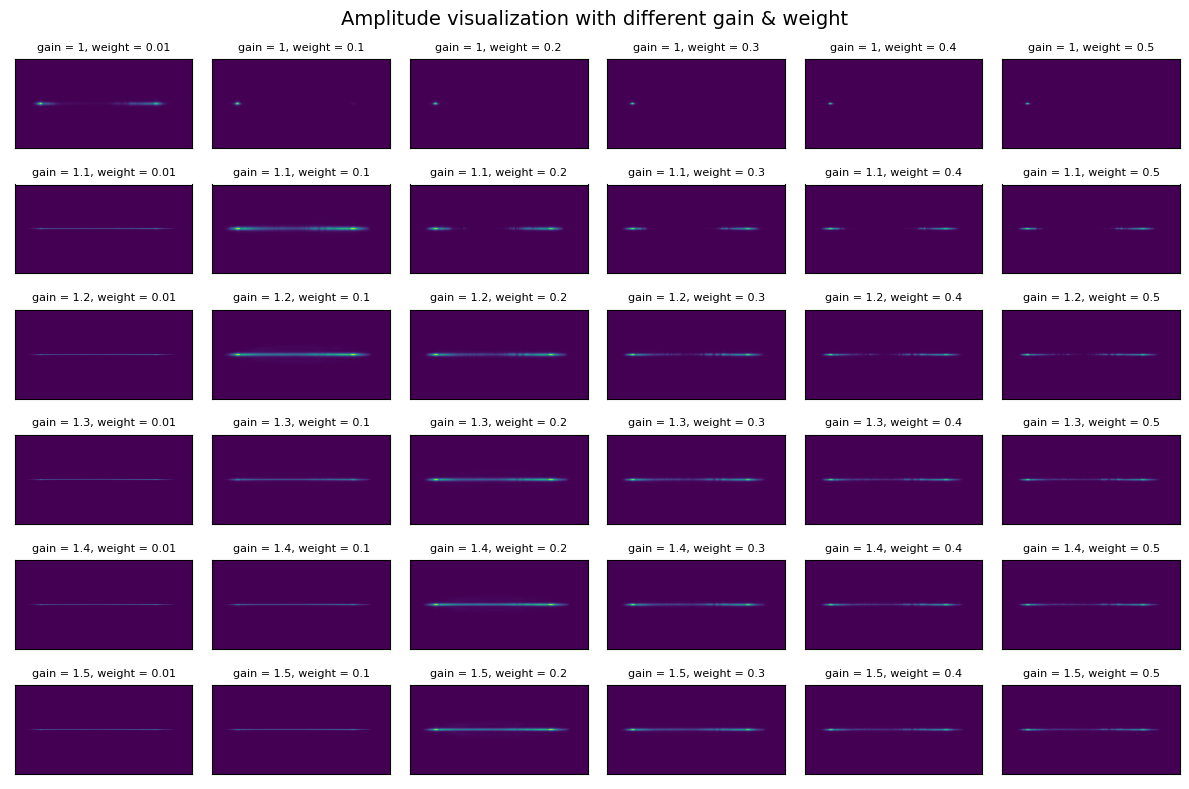

In [47]:
fig, axes = plt.subplots(len(gains), len(weights), figsize=(12, 8), sharex=True, sharey=True)

for i, gain in enumerate(gains):
    for j, weight in enumerate(weights):
        ax = axes[i, j]  


        ax.imshow(results_matrix[i][j], cmap="viridis", aspect="auto")
        ax.set_xticks([])  
        ax.set_yticks([])  
        ax.set_title(f"gain = {gain}, weight = {weight}", fontsize=8)

fig.suptitle("Amplitude visualization with different gain & weight", fontsize=14)
plt.tight_layout()
plt.savefig('weight_gain.jpg')
plt.show()

### Запуск алгорифма при weight = 0.01, gain = 1.1

In [177]:
amplitude, phase, errors, intensities = weighted_gerchberg_saxton(intensities_resized1, z1, lam, 100, 0.01, 1.1, 1e-10)

Iteration 1, Error = 1.068413760904593e-07
Iteration 2, Error = 1.3049548230690792e-07
Iteration 3, Error = 1.321153282695417e-07
Iteration 4, Error = 1.32220453726254e-07
Iteration 5, Error = 1.3222725426394656e-07
Iteration 6, Error = 1.3222769410145675e-07
Iteration 7, Error = 1.3222772254840493e-07
Iteration 8, Error = 1.3222772438823958e-07
Iteration 9, Error = 1.3222772450723394e-07
Iteration 10, Error = 1.3222772451493009e-07
Iteration 11, Error = 1.3222772451542817e-07
Iteration 12, Error = 1.3222772451546027e-07
Iteration 13, Error = 1.3222772451546207e-07
Iteration 14, Error = 1.3222772451546276e-07
Iteration 15, Error = 1.3222772451546136e-07
Iteration 16, Error = 1.3222772451546295e-07
Iteration 17, Error = 1.3222772451546258e-07
Iteration 18, Error = 1.3222772451546377e-07
Iteration 19, Error = 1.322277245154631e-07


KeyboardInterrupt: 

In [147]:
import imageio.v2 as imageio
def plot_intensity(image_folder='intensity_evolution'):
    filenames = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])
    num_images = len(filenames)
    
    cols = min(num_images, 4)  
    rows = (num_images + cols - 1) // cols 
    
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    
    if rows == 1:
        axes = np.array([axes])  
    
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = imageio.imread(os.path.join(image_folder, filenames[i]))
            ax.imshow(img, cmap='viridis')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('evolution.jpg')
    plt.show()

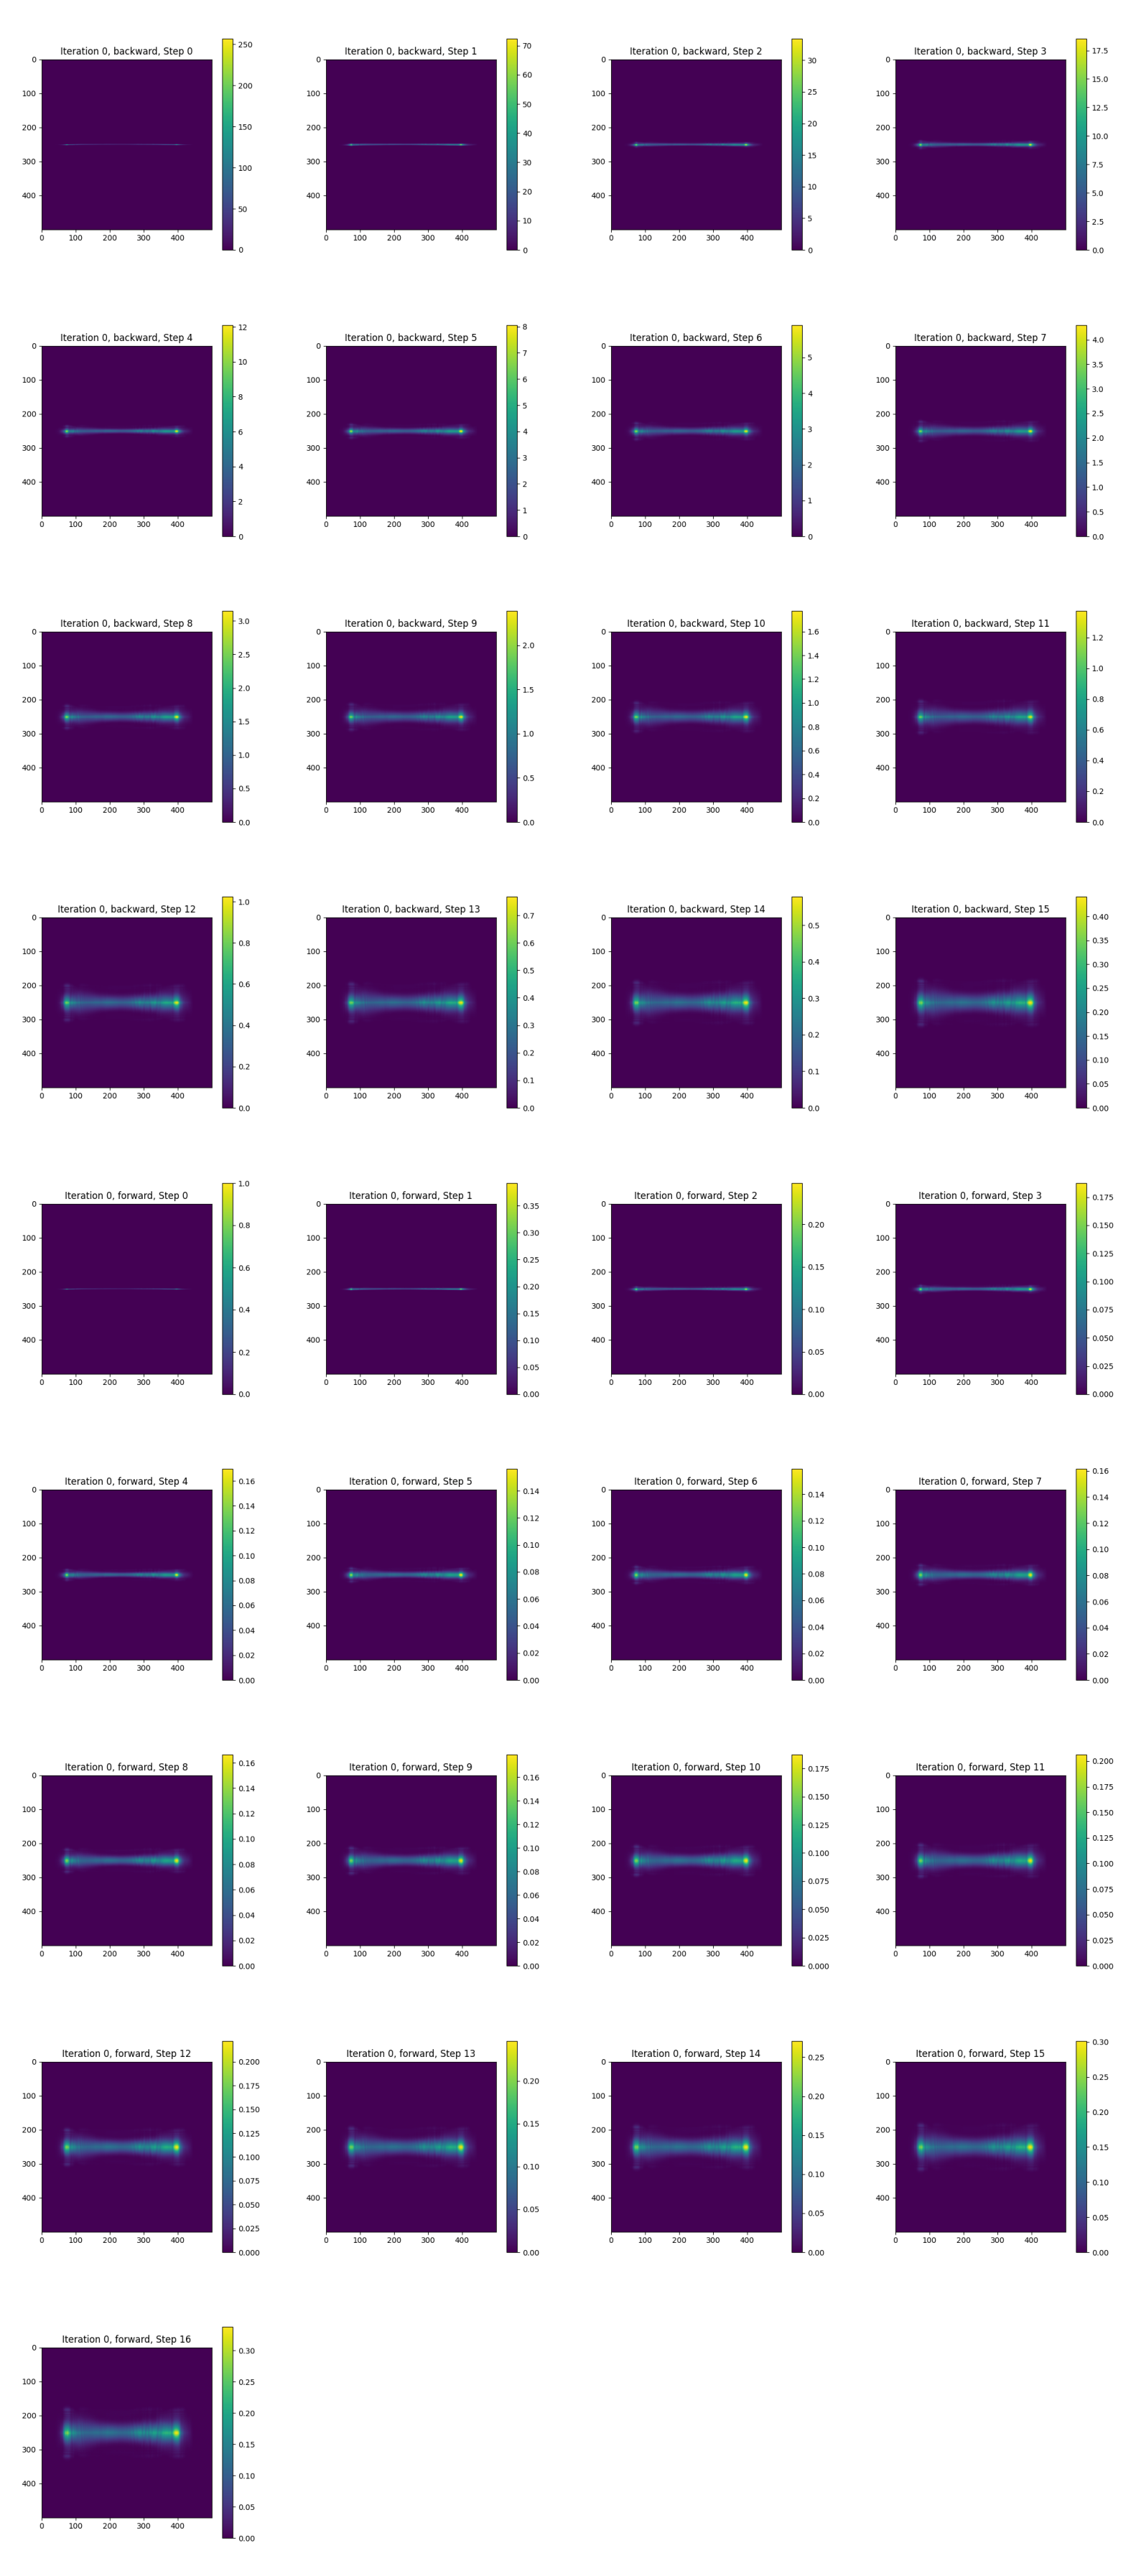

In [148]:
plot_intensity(image_folder='intensity_evolution')

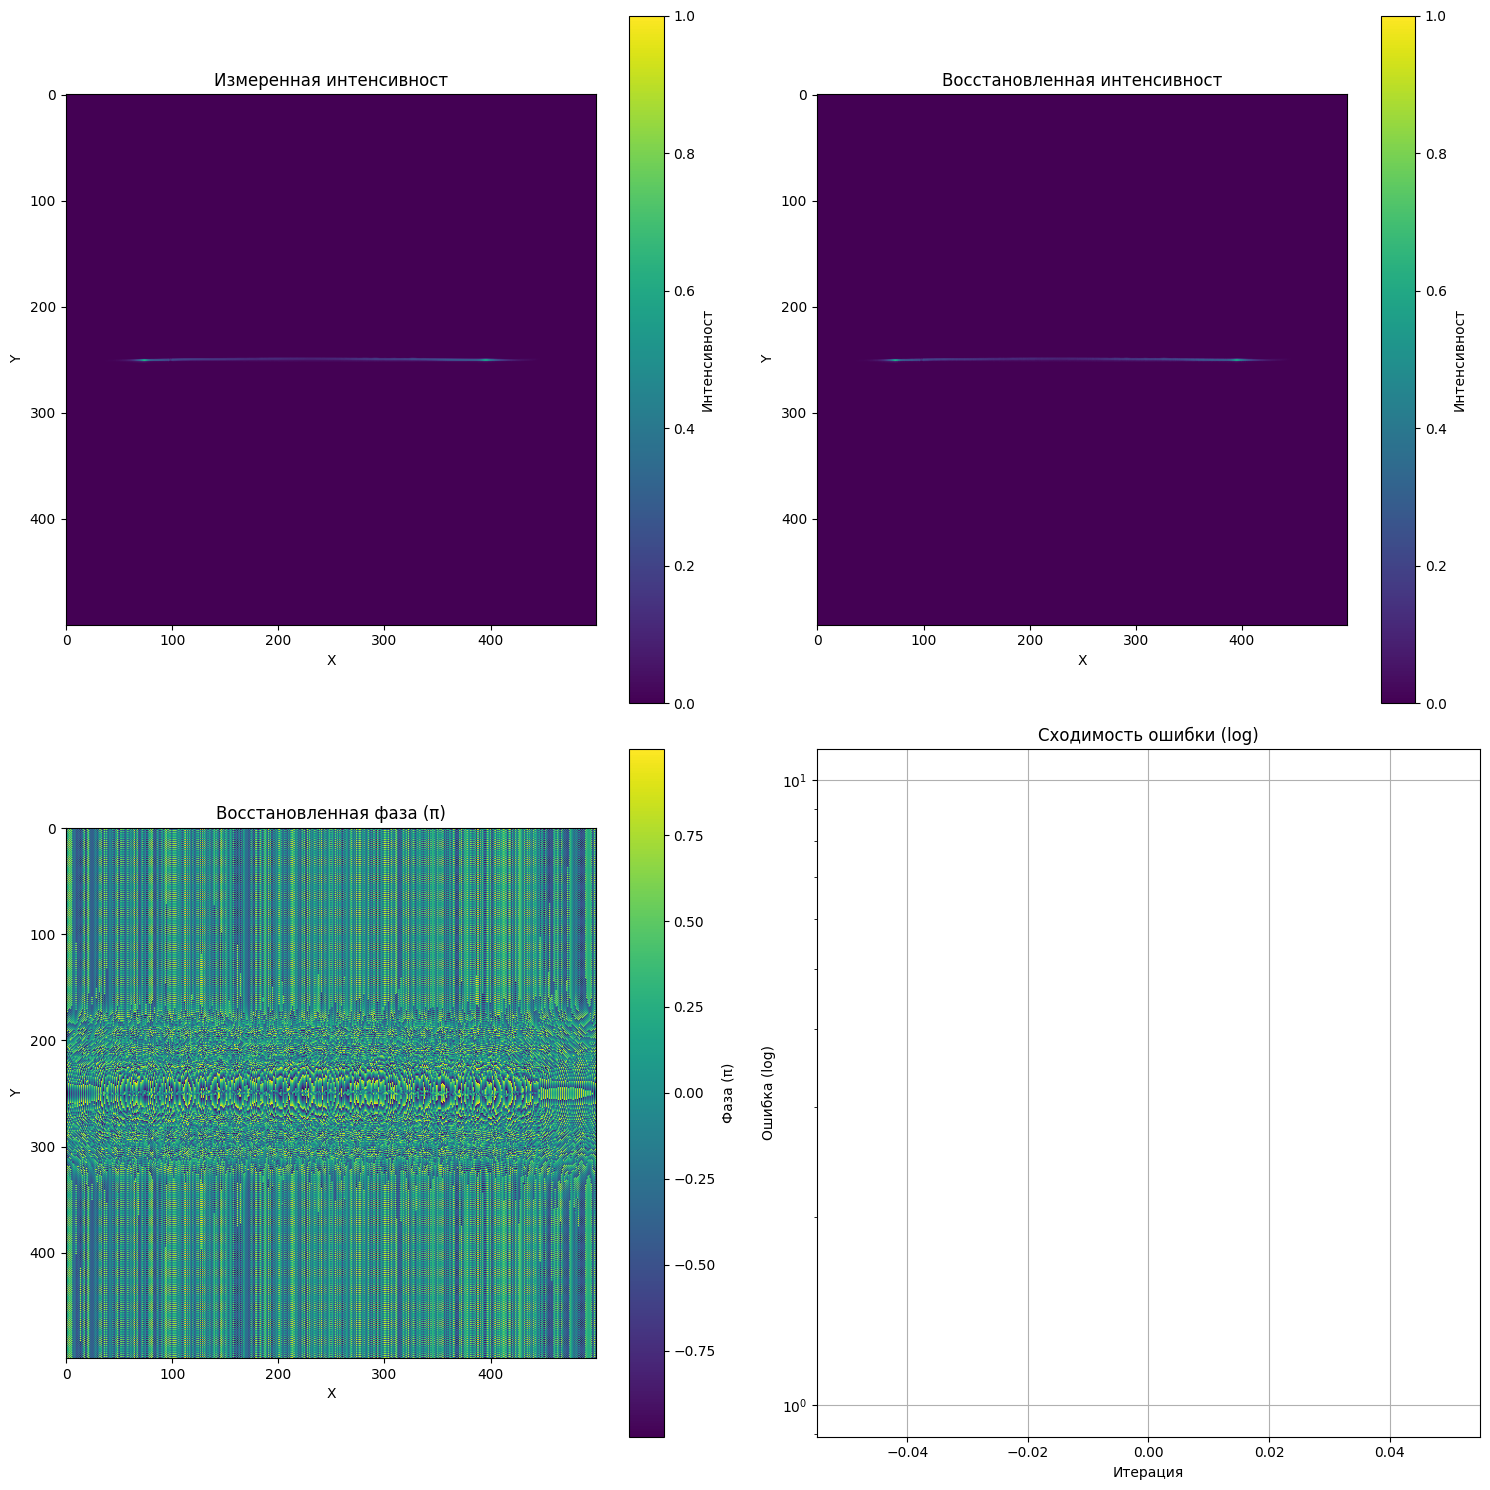

In [174]:
# Нормализация интенсивностей
intensities_ = [intensity / np.max(intensities_resized1) for intensity in intensities_resized1]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

#  График измеренной интенсивности
im1 = axes[0, 0].imshow(intensities_[0], cmap='viridis')
axes[0, 0].set_title("Измеренная интенсивност")
fig.colorbar(im1, ax=axes[0, 0], label="Интенсивност")
axes[0, 0].set_xlabel("X")
axes[0, 0].set_ylabel("Y")

#  График восстановленной интенсивности
im2 = axes[0, 1].imshow(amplitude**2, cmap='viridis')
axes[0, 1].set_title("Восстановленная интенсивност")
fig.colorbar(im2, ax=axes[0, 1], label="Интенсивност")
axes[0, 1].set_xlabel("X")
axes[0, 1].set_ylabel("Y")

#  График восстановленной фазы (в π)
phase_in_pi = phase / np.pi
im3 = axes[1, 0].imshow(phase_in_pi, cmap='viridis')
axes[1, 0].set_title("Восстановленная фаза (π)")
fig.colorbar(im3, ax=axes[1, 0], label="Фаза (π)")
axes[1, 0].set_xlabel("X")
axes[1, 0].set_ylabel("Y")

#  График сходимости ошибки (без первых точек)
axes[1, 1].plot(range(11, len(errors) + 1), errors[10:], marker='o', linestyle='-', color='b')
axes[1, 1].set_title("Сходимость ошибки (log)")
axes[1, 1].set_xlabel("Итерация")
axes[1, 1].set_ylabel("Ошибка (log)")
axes[1, 1].grid(True)
plt.yscale('log')

plt.savefig('recovered_data.jpg')
plt.tight_layout()
plt.show()


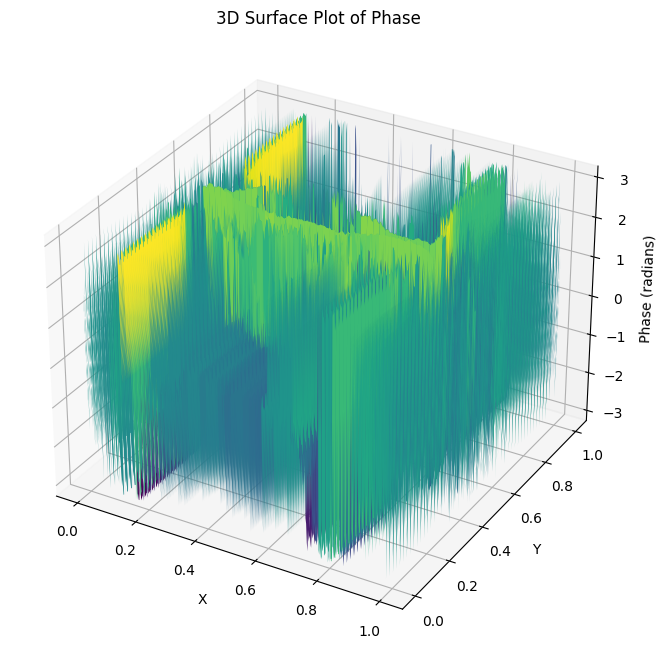

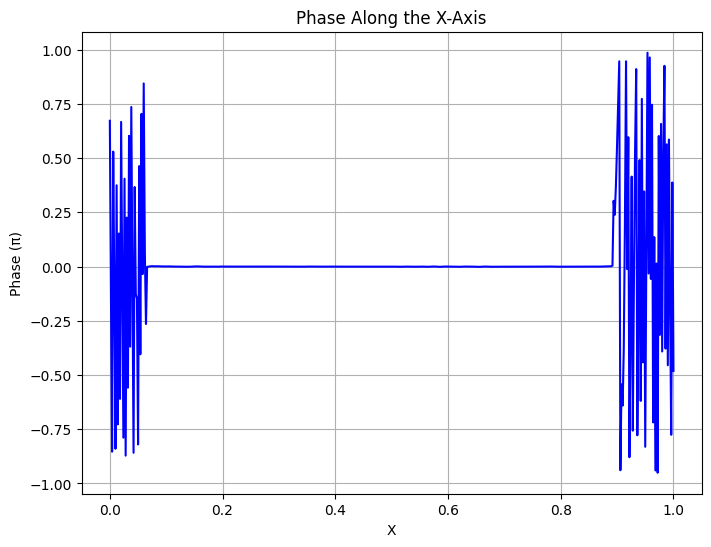

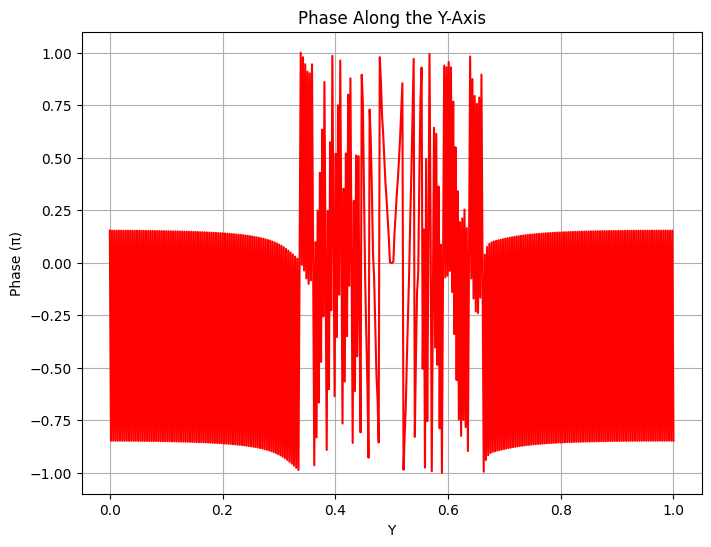

In [171]:
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 1, 500)
y = np.linspace(0, 1, 500)
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, phase, cmap='viridis')
ax.set_title("3D Surface Plot of Phase")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Phase (radians)")
plt.show()

y_index = phase.shape[0] // 2  
phase_x_profile = phase[y_index, :] 
phase_x_profile = phase_x_profile / np.pi

plt.figure(figsize=(8, 6))
plt.plot(x, phase_x_profile, color='b')
plt.title("Phase Along the X-Axis")
plt.xlabel("X")
plt.ylabel("Phase (π)")
plt.grid(True)
plt.show()

x_index = phase.shape[1] // 2  
phase_y_profile = phase[:, x_index]
phase_y_profile = phase_y_profile / np.pi
plt.figure(figsize=(8, 6))
plt.plot(y, phase_y_profile, color='r')
plt.title("Phase Along the Y-Axis")
plt.xlabel("Y")
plt.ylabel("Phase (π)")
plt.grid(True)
plt.show()

### Шаг 0.1 mm

In [131]:
weights = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
gains = [1, 1.1, 1.2, 1.3, 1.4, 1.5]
results_matrix = [[None for _ in weights] for _ in gains]  

for i, gain in enumerate(gains):
    for j, weight in enumerate(weights):
        print(f"Gain = {gain}, weight = {weight}")
        
        amplitude, phase, errors, computed_intensities = weighted_gerchberg_saxton(
            intensities_resized2, z2, lam, iterations=50, weight=weight, gain=gain, tolerance = 1e-10
        )
        
        results_matrix[i][j] = amplitude 

Gain = 1, weight = 0.01
Gain = 1, weight = 0.1
Gain = 1, weight = 0.2
Gain = 1, weight = 0.3
Gain = 1, weight = 0.4
Gain = 1, weight = 0.5
Gain = 1.1, weight = 0.01
Gain = 1.1, weight = 0.1
Gain = 1.1, weight = 0.2
Gain = 1.1, weight = 0.3
Gain = 1.1, weight = 0.4
Gain = 1.1, weight = 0.5
Gain = 1.2, weight = 0.01
Gain = 1.2, weight = 0.1
Gain = 1.2, weight = 0.2
Gain = 1.2, weight = 0.3
Gain = 1.2, weight = 0.4
Gain = 1.2, weight = 0.5
Gain = 1.3, weight = 0.01


/tmp/ipykernel_23327/1267319019.py:98: RuntimeWarning: overflow encountered in square
  computed_intensities.append(np.abs(final_field)**2)
/tmp/ipykernel_23327/1267319019.py:104: RuntimeWarning: overflow encountered in square
  computed_intensities.append(np.abs(final_field)**2)  # Добавляем интенсивность
/tmp/ipykernel_23327/1267319019.py:108: RuntimeWarning: invalid value encountered in divide
  computed_intensities = [intensity / np.max(computed_intensities) for intensity in computed_intensities]


Gain = 1.3, weight = 0.1
Gain = 1.3, weight = 0.2
Gain = 1.3, weight = 0.3
Gain = 1.3, weight = 0.4
Gain = 1.3, weight = 0.5
Gain = 1.4, weight = 0.01
Gain = 1.4, weight = 0.1
Gain = 1.4, weight = 0.2
Gain = 1.4, weight = 0.3
Gain = 1.4, weight = 0.4
Gain = 1.4, weight = 0.5
Gain = 1.5, weight = 0.01
Gain = 1.5, weight = 0.1
Gain = 1.5, weight = 0.2
Gain = 1.5, weight = 0.3
Gain = 1.5, weight = 0.4
Gain = 1.5, weight = 0.5


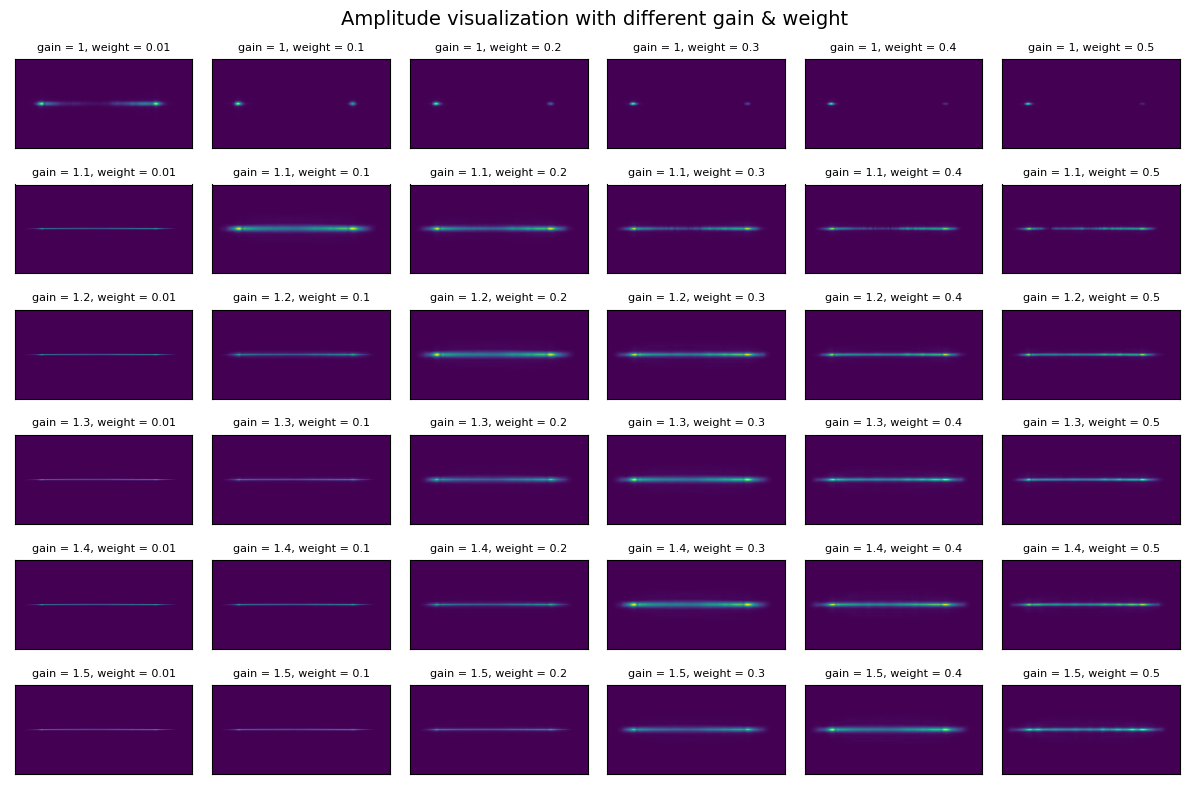

In [132]:
fig, axes = plt.subplots(len(gains), len(weights), figsize=(12, 8), sharex=True, sharey=True)

for i, gain in enumerate(gains):
    for j, weight in enumerate(weights):
        ax = axes[i, j]  


        ax.imshow(results_matrix[i][j], cmap="viridis", aspect="auto")
        ax.set_xticks([])  
        ax.set_yticks([])  
        ax.set_title(f"gain = {gain}, weight = {weight}", fontsize=8)

fig.suptitle("Amplitude visualization with different gain & weight", fontsize=14)
plt.tight_layout()
plt.savefig('weight_gain_0.1mm.jpg')
plt.show()